<a href="https://colab.research.google.com/github/dchlseo/DataScienceProjects/blob/main/DeepLearningBasics/TensorFlow/06_ResNet_functional_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [7]:
def build_resnet(input_shape):
    # Define the input layer with the given shape
    inputs = Input(input_shape)

    # Initial convolutional layer with 32 filters, followed by a max pooling
    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    # Start of the first residual block
    # Convolution with 64 filters and a kernel size of 1x1
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    # Convolution with 64 filters and a kernel size of 3x3
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    # Convolution with 64 filters and a kernel size of 1x1
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    # Adapt the original input of the block (net) to have the same dimensions as net3
    # This is done via a 1x1 convolution so that the shortcut can be connected
    # to the output of the block with an element-wise addition.
    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    # Add the shortcut to the output of the block (element-wise addition)
    net = Add()([net1_1, net3])

    # Start of the second residual block, which is similar to the first block
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    # Add the shortcut to the output of the second block (element-wise addition)
    # Here, the input to the block (net) is directly used without modification
    # because it already has the correct dimensions.
    net = Add()([net, net3])

    # Apply max pooling to reduce the spatial dimensions
    net = MaxPool2D()(net)

    # Flatten the 3D output to 1D to prepare for the dense layer
    net = Flatten()(net)
    # Dense (fully connected) layer with 10 units and softmax activation for classification
    net = Dense(10, activation='softmax')(net)

    # Create the actual model by specifying the inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=net)

    # Return the constructed model
    return model

In [8]:
model = build_resnet((32,32,3))

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 16, 32)           896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)             0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 64)             2112      ['max_pooling2d_2[0][0]'

### Model training using cifar10 dataset

In [14]:
class DataLoader():

  def __init__(self):
    (self.train_x, self.train_y), \
      (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()

  def validate_pixel_scale(self, x):
    return 255 >= x.max() and 0 <= x.min()

  def scale(self, x):
    return (x/255.0).astype(np.float32)  # range 0~1

  def preprocess_dataset(self, dataset):
    (feature, target) = dataset

    validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
    validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])

    # scaling
    scaled_x = np.array([self.scale(x) for x in validated_x])

    # # expand
    # expanded_x = scaled_x[:, :, :, np.newaxis]  # new axis is for color (1=gray, 3=color)

    # label encoding
    ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])

    return scaled_x, np.squeeze(ohe_y, axis=1)

  def get_train_dataset(self):
    return self.preprocess_dataset((self.train_x, self.train_y))

  def get_test_dataset(self):
    return self.preprocess_dataset((self.test_x, self.test_y))


In [15]:
loader = DataLoader()
train_x, train_y = loader.get_train_dataset()
test_x, test_y = loader.get_test_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [16]:
lr = 0.03
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [17]:
hist = model.fit(train_x, train_y, epochs=10, batch_size=128, validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 36s 89ms/step - loss: 1.9506 - accuracy: 0.3209 - val_loss: 1.7177 - val_accuracy: 0.3940
Epoch 2/10
391/391 [==============================] - 35s 89ms/step - loss: 1.7212 - accuracy: 0.3796 - val_loss: 1.7733 - val_accuracy: 0.3422
Epoch 3/10
391/391 [==============================] - 35s 90ms/step - loss: 1.7002 - accuracy: 0.3875 - val_loss: 1.7011 - val_accuracy: 0.3786
Epoch 4/10
391/391 [==============================] - 35s 89ms/step - loss: 1.6934 - accuracy: 0.3885 - val_loss: 1.6942 - val_accuracy: 0.3830
Epoch 5/10
391/391 [==============================] - 35s 89ms/step - loss: 1.6756 - accuracy: 0.3935 - val_loss: 1.6681 - val_accuracy: 0.3869
Epoch 6/10
391/391 [==============================] - 35s 90ms/step - loss: 1.6869 - accuracy: 0.3905 - val_loss: 1.7134 - val_accuracy: 0.3713
Epoch 7/10
391/391 [==============================] - 35s 88ms/step - loss: 1.6765 - accuracy: 0.3945 - val_loss: 1.6799 - val_accuracy:

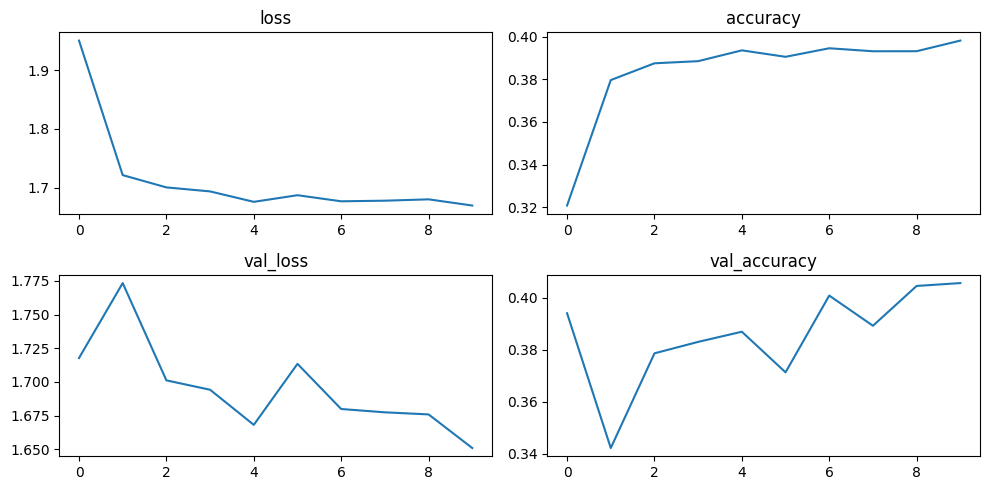

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()